In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
cuda = True
seed = 42
use_cuda = cuda and torch.cuda.is_available()

# Set seed
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# Handel GPU stochasticity
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if use_cuda else "cpu")
device

/home/user/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
original_size = 96
cropped_size = 64
num_channels = 3
num_classes = 10


## STL-10 dataset

The images in STL-10 dataset simiilar to CIFAR-10 dataset but with higher resolution - 3 color channels of 96x96 images.

![stl_10.png](stl_10.png)

## Data Loader

In [4]:
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean, std)])
train_transform=transforms.Compose([
                    transforms.Pad(4),
                    transforms.RandomCrop(cropped_size),
                    # transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
					# transforms.RandomRotation(degrees=(0, 20))
                    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

test_transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.CenterCrop(cropped_size),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  ])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
valset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=test_transform)
targets = trainset.labels
targets_idx = np.arange(len(targets))
train_idx, valid_idx = train_test_split(targets_idx, test_size=0.2, random_state=seed,shuffle=True, stratify=targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,num_workers=4, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(valset, batch_size=16,num_workers=4, sampler=val_sampler)
testset = torchvision.datasets.STL10(root='./data', split='test',download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

## Visualize the data

In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imgs_dict = dict(zip(classes, [[],[],[],[],[],[],[],[],[],[]]))
counters_dict = dict(zip(classes, [0]*10))

while not all(v >= 4 for v in counters_dict.values()):
    images, labels = dataiter.next()
    for image, label in zip(images, labels):
        img_class = classes[label]
        if(counters_dict[img_class] < 4):
            imgs_dict[img_class].append(image)
            counters_dict[img_class] += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane


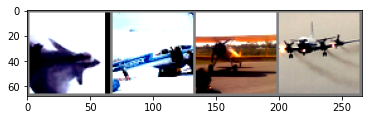

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


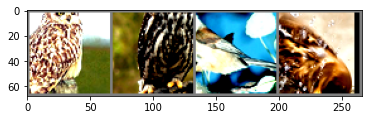

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


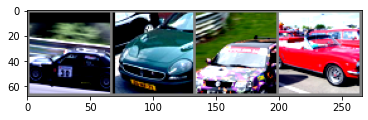

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


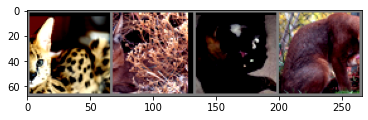

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


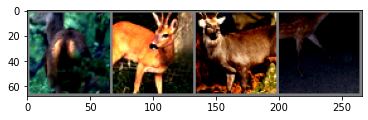

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


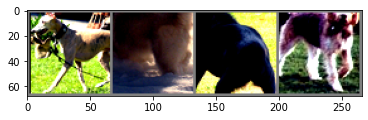

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


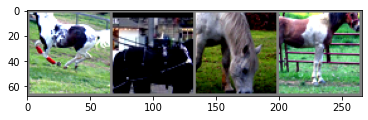

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


monkey


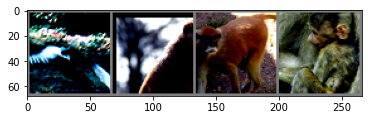

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


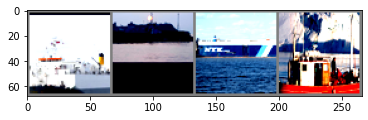

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


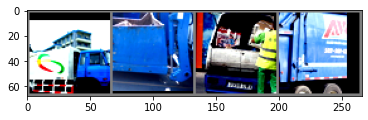

In [7]:
# show images
for l,imgs in imgs_dict.items():
    print(l)
    imshow(torchvision.utils.make_grid(imgs, nrow=4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


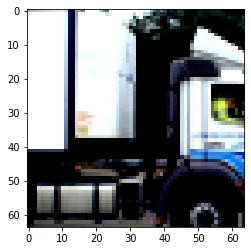

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


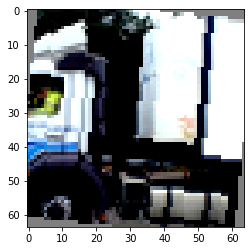

In [9]:
# show an image and its augmented version:
# we choose to add to our dataloader a horizontal flip, and a random rotation of 20 degrees:
rotater = transforms.RandomRotation(degrees=(0,10))
fliper = transforms.RandomHorizontalFlip(p=0.5)
fliper_for_visualization = transforms.RandomHorizontalFlip(p=1)
images,_ = dataiter.next()
img = images[0]
plt.figure()
imshow(img)
img_aug = rotater(img)
img_aug = fliper_for_visualization(img_aug)
plt.figure()
imshow(img_aug)

In [10]:
def train(net, trainloader, valloader, num_epochs=100, validation_ratio=0.2, augment=True):
	criterion = nn.CrossEntropyLoss()
	# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
	optimizer = optim.Adam(net.parameters(), lr=0.0001)
	epoch_pbar = tqdm(range(num_epochs))

	for epoch in epoch_pbar:  # loop over the dataset multiple times
		running_loss = 0.0
		correct_train = 0
		total_train = 0
		net.num_epochs += 1
		counter = 0
		for i, data in enumerate(trainloader, 0):
			# get the inputs; data is a list of [inputs, labels]
			counter += 1
			inputs, labels = data
			inputs = inputs.to(device)
			labels = labels.to(device)
				#train:

			total_train += labels.size(0)

			if augment: # augmentation
				inputs = rotater(inputs)
				inputs = fliper(inputs)

			# zero the parameter gradients
			optimizer.zero_grad()

			# forward + backward + optimize
			outputs = net(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			_, predicted = torch.max(outputs.data, 1)
			correct_train += (predicted == labels).sum().item()

			# print statistics
			running_loss += loss.item()
			# if i % 2000 == 1999:    # print every 2000 mini-batches
			# 	print('[%d, %5d] loss: %.3f' %
			# 		(epoch + 1, i + 1, running_loss / 2000))
			# 	running_loss = 0.0

		epoch_loss = running_loss/float(counter)
		train_acc = 100*correct_train/total_train
		net.train_loss_list.append(epoch_loss)
		net.train_accuracy.append(train_acc)

		#validation
		val_los,val_acc = test(net,valloader, print_res=False)
		net.val_loss_list.append(val_los)
		net.val_accuracy.append(val_acc)
		epoch_pbar.set_postfix({'epoch': epoch, 'train loss': epoch_loss, 'train_accuracy': train_acc, 'val loss': val_los, 'val_accuracy': val_acc})
		# epoch_pbar.set_postfix({'epoch': epoch, 'train accuracy': train_acc, 'train loss': train_loss, \
        #                      'val accuracy': val_acc, 'val loss': val_loss})

	print('Finished Training')


In [11]:
def test(net, testloader, print_res = True):
    correct = 0
    total = 0
    running_loss = 0
    counter = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in testloader:
            counter += 1
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss)
            _, predicted = torch.max(outputs.data, 1)
            total += float(labels.size(0))
            correct += (predicted == labels).sum().item()
            
    los = running_loss / float(counter)	
    acc = 100 * correct / total
    if print_res:
	    print(f'Accuracy of the network on the {total} test images: %d %%' % (acc))
	
    return los, acc

In [12]:
def show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy,
						num_epochs, title, figsize = (8, 8)):

	fig, axes = plt.subplots(1, 2, figsize=figsize);
	axes[0].set_xlabel('epochs')
	axes[0].set_ylabel('loss')
	axes[0].plot(range(len(train_loss_list)), train_loss_list, label="Train", color='blue')
	axes[0].plot(range(len(val_loss_list)), val_loss_list, label="Validation", color='red')
	axes[0].legend()
	axes[0].set_title('Loss vs Epoch')


	axes[1].set_xlabel('epochs')
	axes[1].set_ylabel('accuracy')  # we already handled the x-label with ax1
	axes[1].plot(range(len(train_accuracy)), train_accuracy, label="Train", color='blue')
	axes[1].plot(range(len(val_accuracy)), val_accuracy, label="Validation", color='red')
	axes[1].legend()
	axes[1].set_title('Accuracy vs Epoch')

	fig.suptitle(title)


	#     fig.suptitle('Logistic Regression:\n\n learning rate = {}   |   batch size = {}   |   L2 lambda = {}'
	#                      .format(lr, batch_size, l2_lambda))

	#     return fig;

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(cropped_size*cropped_size*num_channels, num_classes).to(device)
        )
        self.num_epochs = 0
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_accuracy = []
        self.val_accuracy = []

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def history(self):
        return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs


In [ ]:
net = LogisticRegression()
summary(net, (num_channels, cropped_size, cropped_size))
train(net, trainloader, valloader)  


In [ ]:
show_learning_curve(*net.history(), title="Learning Curves - Logistic Regression")


In [ ]:
test(net, testloader)

In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten().to(device)
        self.linear_relu_stack = nn.Sequential(
	        nn.Linear(cropped_size*cropped_size*num_channels, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
			nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Dropout(0.5),
			nn.Linear(512, 512),
            nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Dropout(0.5),
			nn.Linear(512, 512),
            nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Dropout(0.5),
            nn.Linear(512, 10)
        ).to(device)
        self.num_epochs = 0
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_accuracy = []
        self.val_accuracy = []

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def history(self):
        return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs

In [ ]:
net = FullyConnectedNN()
train(net, trainloader, valloader,200)  
show_learning_curve(*net.history(), title="Learning Curves - Fully Connected NN")

In [ ]:
test(net, testloader)

In [ ]:
class ConvNN(nn.Module):
	def __init__(self):
		super(ConvNN, self).__init__()
		self.feature_extraction = nn.Sequential(
			nn.Conv2d(num_channels, 128, 3),   # 64  64  3  => 31  31 
			nn.ReLU(),
			nn.BatchNorm2d(128),
			nn.MaxPool2d(2),
			nn.Conv2d(128, 64, 3),
			nn.ReLU(),
			nn.BatchNorm2d(64),
			nn.MaxPool2d(2),
		).to(device)
		self.flatten = nn.Flatten().to(device)
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(12544, 1024),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(1024, 512),
            nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(512, 10)
		).to(device)

		self.num_epochs = 0
		self.train_loss_list = []
		self.val_loss_list = []
		self.train_accuracy = []
		self.val_accuracy = []

	def forward(self, x):
		x = self.feature_extraction(x)
		x = self.flatten(x) 
		logits = self.linear_relu_stack(x)
		return logits

	def history(self):
		return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs

In [ ]:
net = ConvNN()
summary(net, (num_channels, cropped_size, cropped_size))

In [ ]:
train(net, trainloader, valloader, 200)  
show_learning_curve(*net.history(), title="Learning Curves - Convolutional NN")

In [ ]:
test(net,testloader)

In [13]:
class MobileNetV2FetureExt_FrozenNN(nn.Module):
	def __init__(self, pretrained=True):
		super(MobileNetV2FetureExt_FrozenNN, self).__init__()
		self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True).to(device)
		# Freeze all layers
		for param in self.feature_extractor.parameters():
			param.requires_grad = False
		# Unfreeze last layer (1000 neurons):
		params = self.feature_extractor.state_dict()
		params.get('classifier.1.weight').requires_grad = True
		params.get('classifier.1.bias').requires_grad = True
		# Add the top layer to the model.
		# It consists of Relu, dropout, and an additional Fully Connected (1000 neurons as well) with
		# Relu and dropout as well. After that comes the classification layer (10 neurons)
		self.linear_relu_stack = nn.Sequential(
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 1000),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 10)).to(device)


		self.num_epochs = 0
		self.train_loss_list = []
		self.val_loss_list = []
		self.train_accuracy = []
		self.val_accuracy = []

	def forward(self, x):

		x = self.feature_extractor(x)
		# x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits

	def history(self):
		return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs


In [14]:

net = MobileNetV2FetureExt_FrozenNN()
summary(net, (num_channels, cropped_size, cropped_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
             ReLU6-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 96, 32, 32]           1,536
      BatchNorm2d-11           [-1, 96, 32, 32]             192
            ReLU6-12           [-1, 96, 32, 32]               0
           Conv2d-13           [-1, 96, 16, 16]             864
      BatchNorm2d-14           [-1, 96,

Using cache found in /home/user/.cache/torch/hub/pytorch_vision_v0.10.0


100%|██████████| 40/40 [09:14<00:00, 13.87s/it, epoch=39, train loss=1.29, train_accuracy=54.1, val loss=1.17, val_accuracy=60.3]


Finished Training


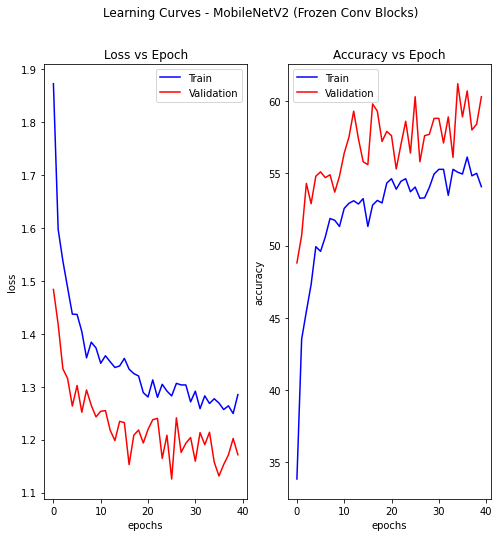

In [15]:
train(net, trainloader, valloader,40)
show_learning_curve(*net.history(), title="Learning Curves - MobileNetV2 (Frozen Conv Blocks)")

In [16]:
test(net,testloader)

Accuracy of the network on the 8000.0 test images: 60 %


(1.1337714454531669, 60.1875)

In [17]:
class MobileNetV2FetureExtNN(nn.Module):
	def __init__(self, pretrained=True):
		super(MobileNetV2FetureExtNN, self).__init__()
		self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True).to(device)

		# This time we only add the top layer to the model.
		# It consists of Relu, dropout, and an additional Fully Connected (1000 neurons as well) with
		# Relu and dropout as well. After that comes the classification layer (10 neurons)
		self.linear_relu_stack = nn.Sequential(
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 1000),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 10)).to(device)


		self.num_epochs = 0
		self.train_loss_list = []
		self.val_loss_list = []
		self.train_accuracy = []
		self.val_accuracy = []

	def forward(self, x):

		x = self.feature_extractor(x)
		# x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits

	def history(self):
		return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs

In [18]:
net = MobileNetV2FetureExtNN(pretrained = False)
summary(net, (num_channels, cropped_size, cropped_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
             ReLU6-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 96, 32, 32]           1,536
      BatchNorm2d-11           [-1, 96, 32, 32]             192
            ReLU6-12           [-1, 96, 32, 32]               0
           Conv2d-13           [-1, 96, 16, 16]             864
      BatchNorm2d-14           [-1, 96,

Using cache found in /home/user/.cache/torch/hub/pytorch_vision_v0.10.0


100%|██████████| 60/60 [35:43<00:00, 35.73s/it, epoch=59, train loss=0.214, train_accuracy=92.4, val loss=0.741, val_accuracy=78.7]


Finished Training


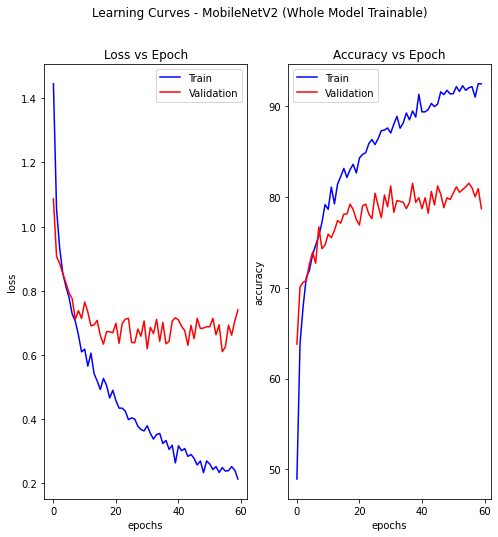

In [19]:
train(net, trainloader, valloader, 60)
show_learning_curve(*net.history(), title="Learning Curves - MobileNetV2 (Whole Model Trainable)")

In [20]:
test(net,testloader)

Accuracy of the network on the 8000.0 test images: 80 %


(0.6766135616898536, 80.1125)